In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import classification_report,accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")

In [34]:
data = pd.read_csv("/content/WineQT.csv")
df = data.copy()

# Data Analysis

In [35]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [36]:
df.shape

(1143, 13)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


In [38]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1143.0,8.311111,1.747595,4.60000,7.10000,7.90000,9.100000,15.90000
volatile acidity,1143.0,0.531339,0.179633,0.12000,0.39250,0.52000,0.640000,1.58000
citric acid,1143.0,0.268364,0.196686,0.00000,0.09000,0.25000,0.420000,1.00000
residual sugar,1143.0,2.532152,1.355917,0.90000,1.90000,2.20000,2.600000,15.50000
chlorides,1143.0,0.086933,0.047267,0.01200,0.07000,0.07900,0.090000,0.61100
free sulfur dioxide,1143.0,15.615486,10.250486,1.00000,7.00000,13.00000,21.000000,68.00000
total sulfur dioxide,1143.0,45.914698,32.782130,6.00000,21.00000,37.00000,61.000000,289.00000
density,1143.0,0.996730,0.001925,0.99007,0.99557,0.99668,0.997845,1.00369
pH,1143.0,3.311015,0.156664,2.74000,3.20500,3.31000,3.400000,4.01000
sulphates,1143.0,0.657708,0.170399,0.33000,0.55000,0.62000,0.730000,2.00000


In [39]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Id                      0
dtype: int64

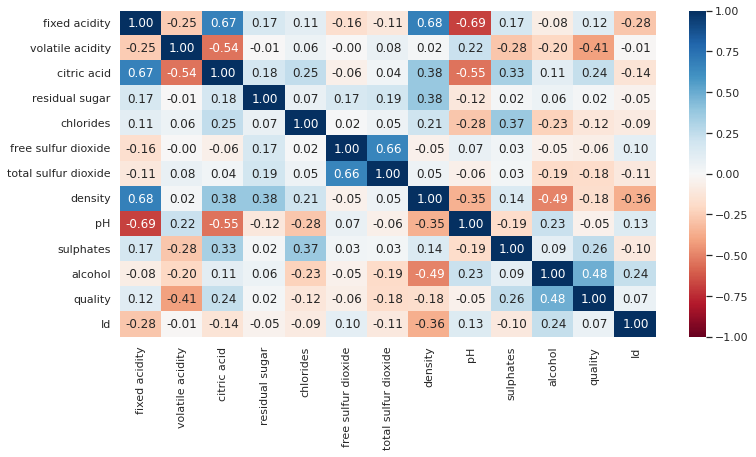

In [40]:
fig, ax = plt.subplots(figsize=(12,6))
corr=df.corr()
sns.heatmap(corr, annot=True, cmap="RdBu",vmin=-1,vmax=1,fmt=".2f")

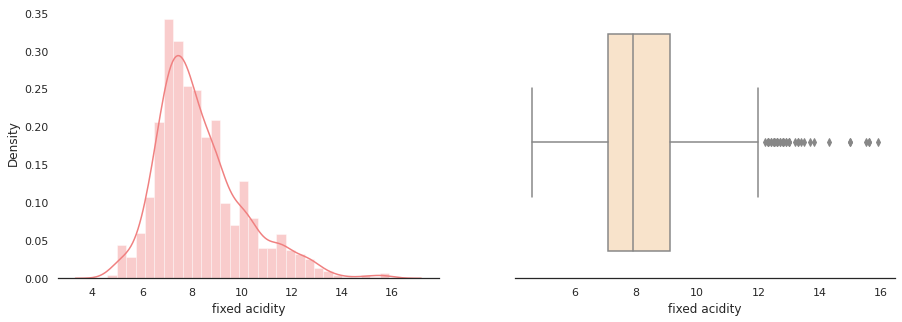

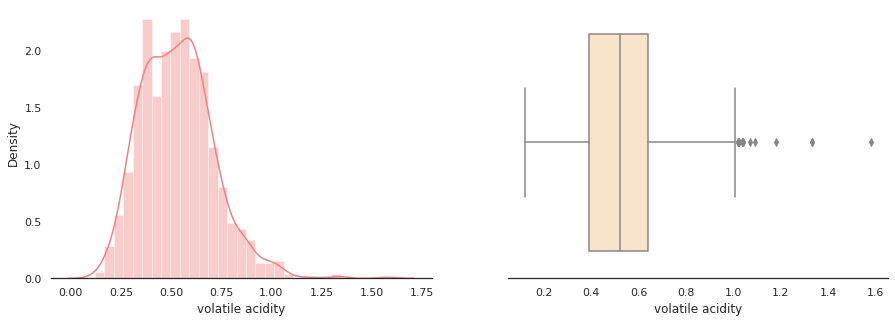

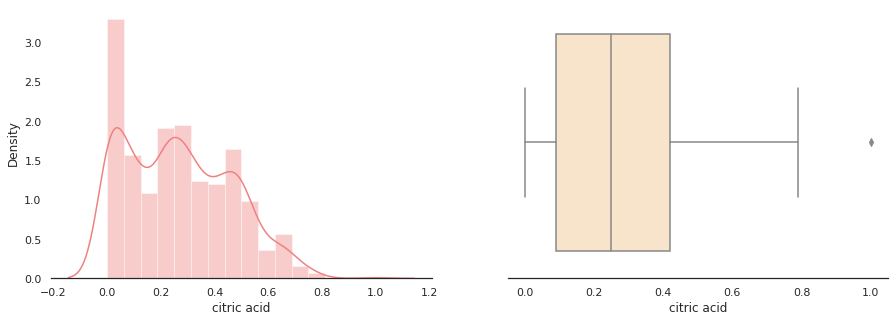

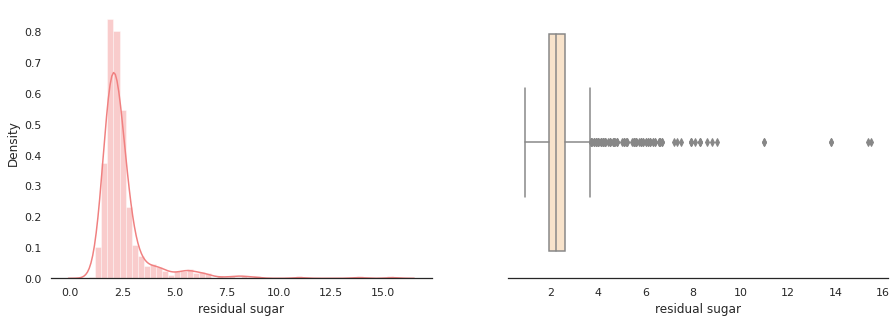

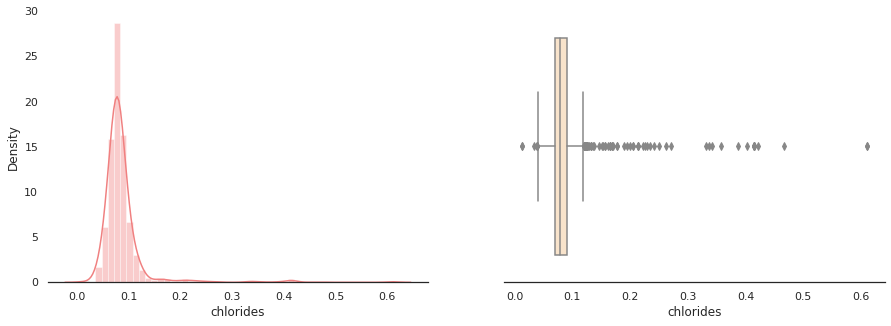

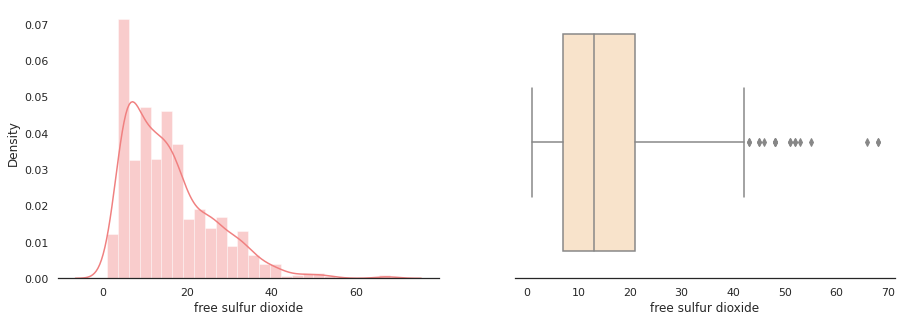

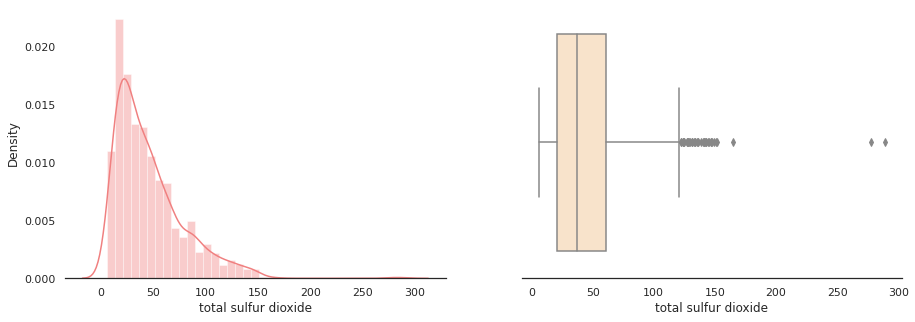

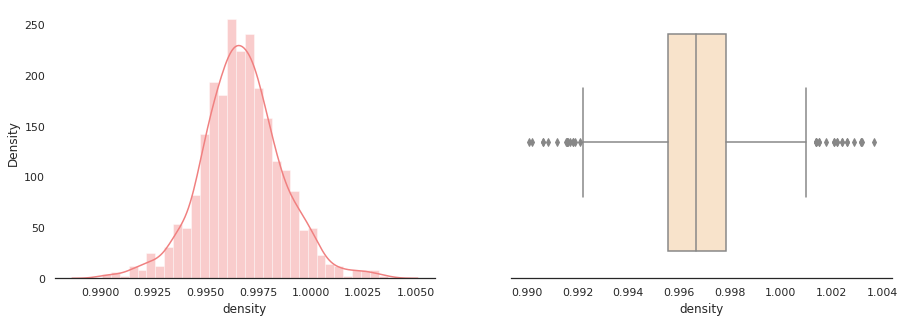

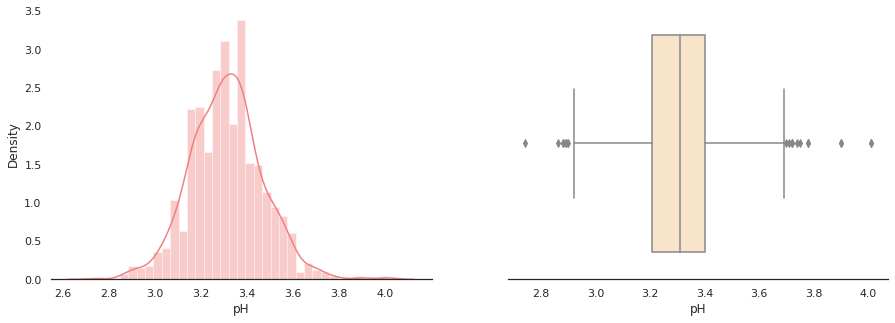

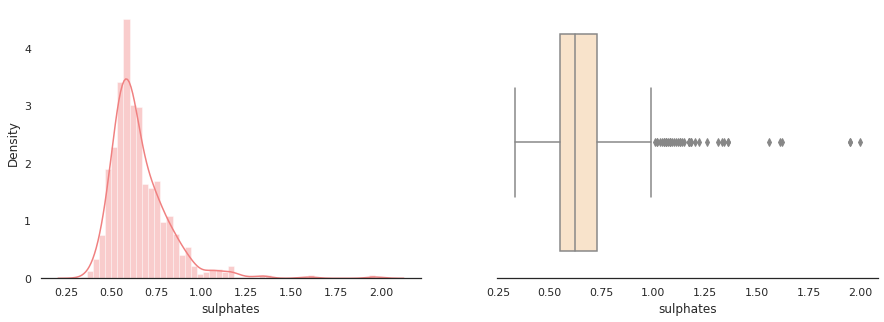

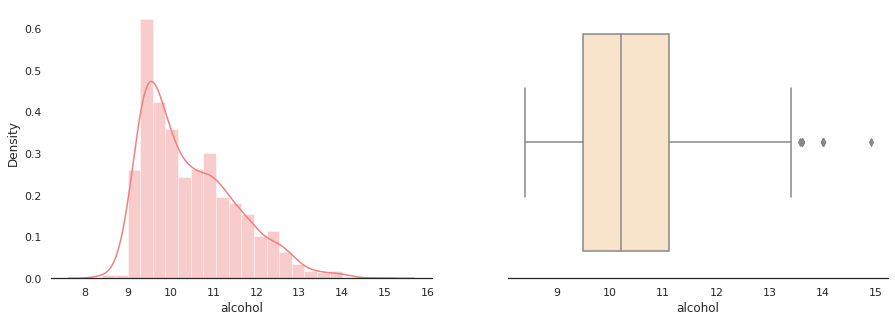

In [41]:
features = df.drop(columns=["quality","Id"],axis=1)
target = df["quality"]

def visualization(df):
    """
    The function takes in a dataframe and plots two graphs:
    
    1. A histogram of the distribution of the features
    2. A boxplot of the distribution of the features
    
    :param df: the dataframe
    """
    for i in features.columns:
        
        fig,ax = plt.subplots(figsize=(15,5),nrows=1,ncols=2)
        sns.set(style="white", palette="muted", color_codes=True)
        sns.despine(left=True)
        sns.distplot(x=df[i],ax=ax[0],color="lightcoral",kde=True).set_xlabel(f"{i}")
        sns.boxplot(x=df[i],ax=ax[1],color="bisque")
        
visualization(features)

<Figure size 432x288 with 0 Axes>

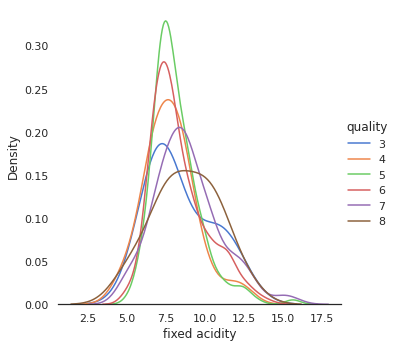

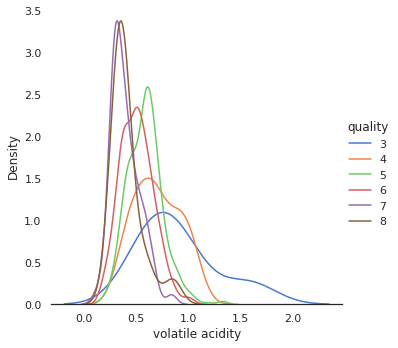

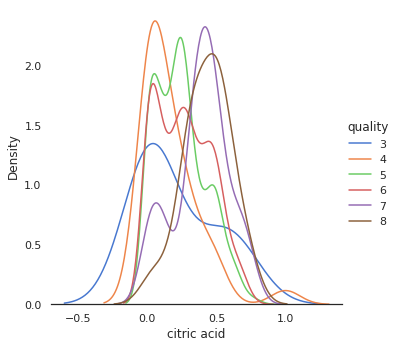

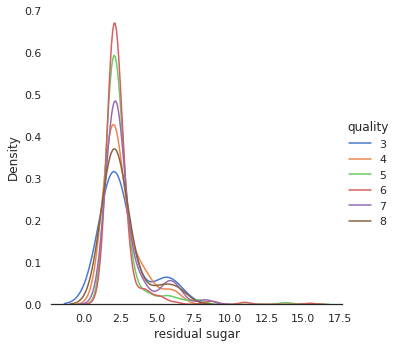

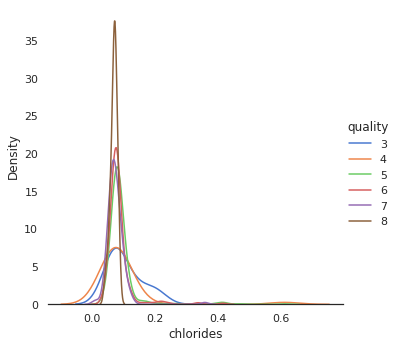

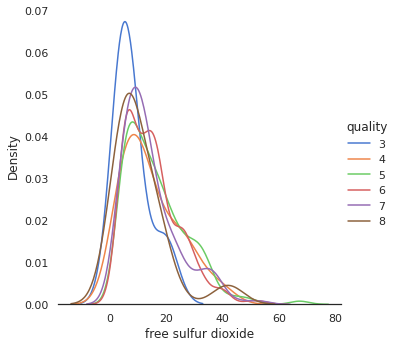

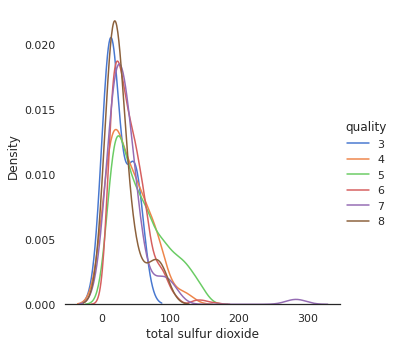

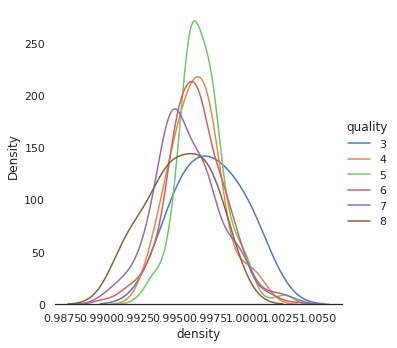

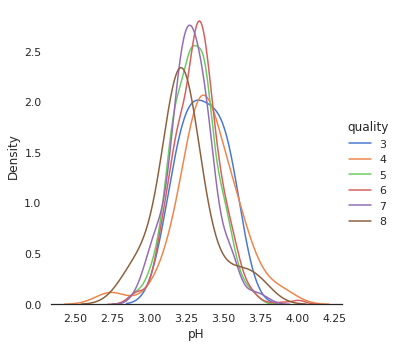

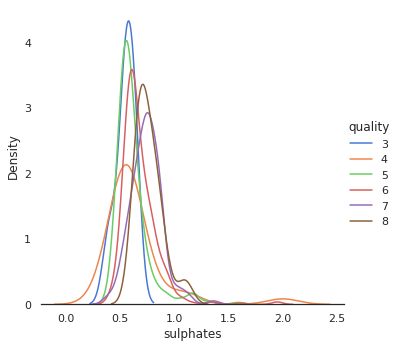

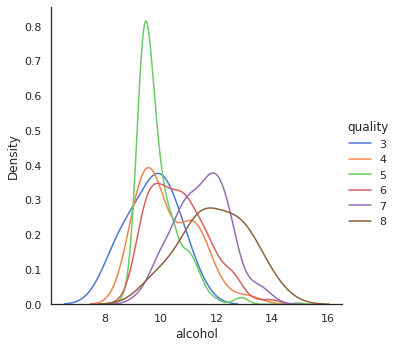

In [42]:
# This is a for loop that iterates through each column in the dataframe.
for i in features.columns:
        
        sns.set(style="white", palette="muted", color_codes=True)
        sns.despine(left=True)
        
        (sns.FacetGrid(df,hue="quality",height=5).map(sns.kdeplot,f"{i}").add_legend())

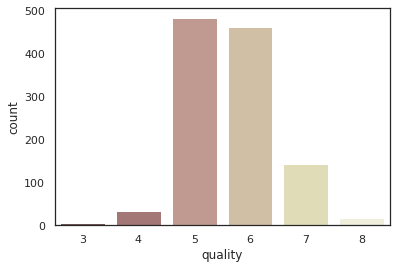

In [43]:
# Plotting the count of the target variable.
sns.countplot(target, palette = 'pink')
plt.show()

In [44]:
# Creating a list of highly correlated features.
corr_matrix = df.corr().abs()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
tri_df = corr_matrix.mask(mask)
h_corr = [c for c in tri_df.columns if any(tri_df[c] > 0.5)]
h_corr

['fixed acidity', 'volatile acidity', 'citric acid', 'free sulfur dioxide']

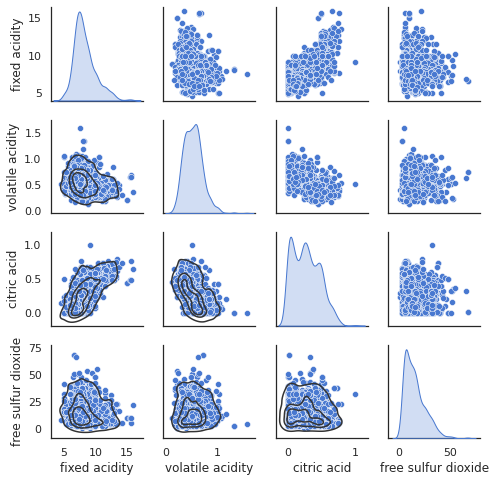

In [45]:
# Creating a pairplot with the dataframe `df[h_corr]` and setting the height of the plot to 1.7.
g=sns.pairplot(data=df[h_corr],height=1.7,diag_kind="kde").add_legend();
g.map_lower(sns.kdeplot, levels=4, color=".2")

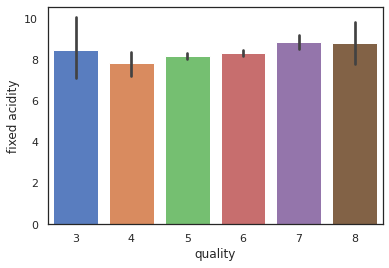

In [46]:
#['fixed acidity', 'volatile acidity', 'citric acid', 'free sulfur dioxide']
sns.barplot(x="quality",y="fixed acidity",data=df)

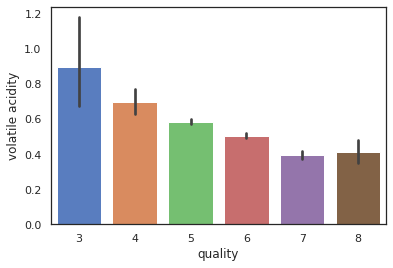

In [47]:
sns.barplot(x="quality",y="volatile acidity",data=df)

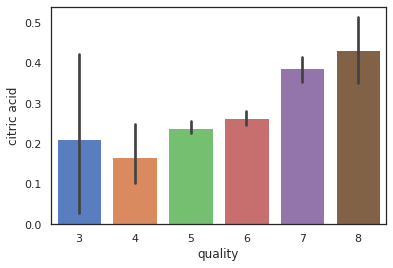

In [48]:
sns.barplot(x="quality",y="citric acid",data=df)

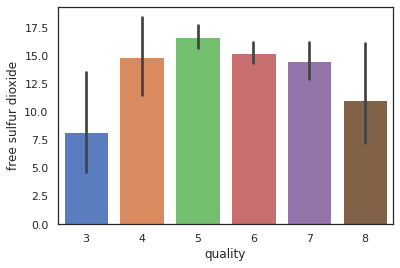

In [49]:
sns.barplot(x="quality",y="free sulfur dioxide",data=df)

# Outlier Engineering

In [50]:
def skewed_boundaries(data):
    """
    This function takes in a dataframe and returns a dataframe with the skewed boundaries of the columns
    
    :param data: the dataframe
    """
    for i in data.columns:
        IQR = data[i].quantile(0.75) - data[i].quantile(0.25)

        lower_boundary = data[i].quantile(0.25) - (IQR * 1.5)
        upper_boundary = data[i].quantile(0.75) + (IQR * 1.5)
        
        data[i]= np.where(data[i] > upper_boundary, upper_boundary,
                       np.where(data[i] < lower_boundary, lower_boundary, data[i]))  
    
skewed_boundaries(features)

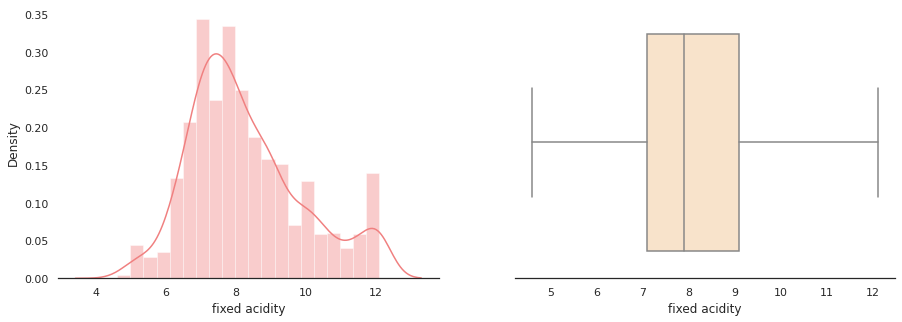

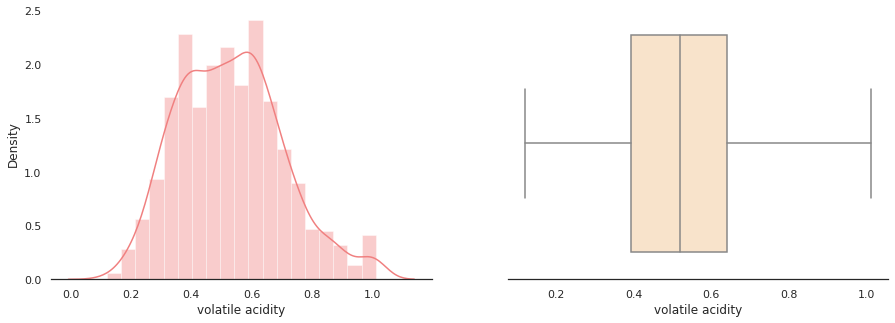

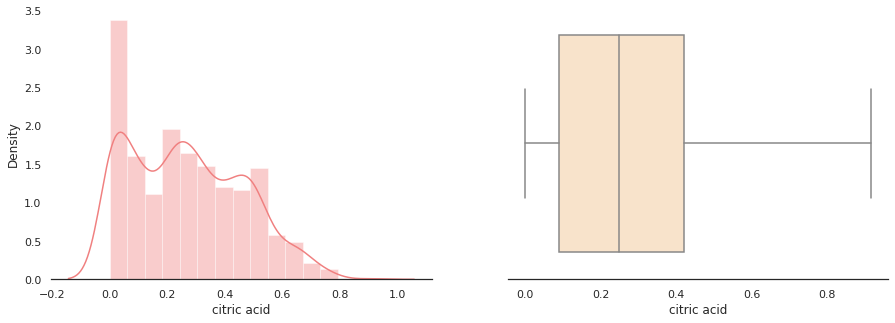

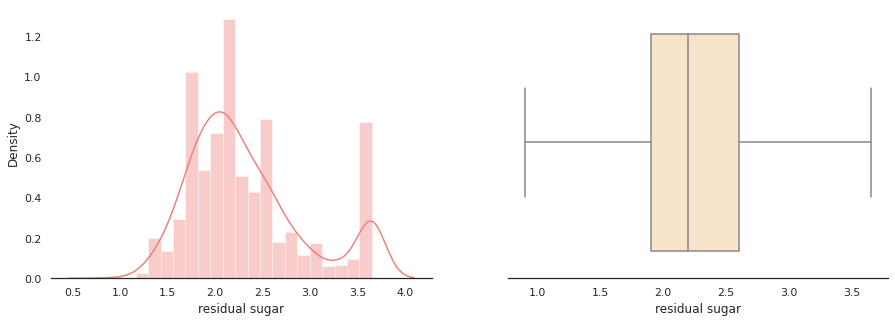

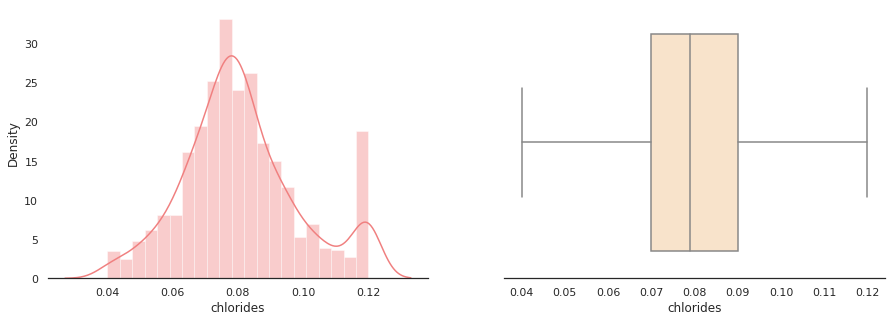

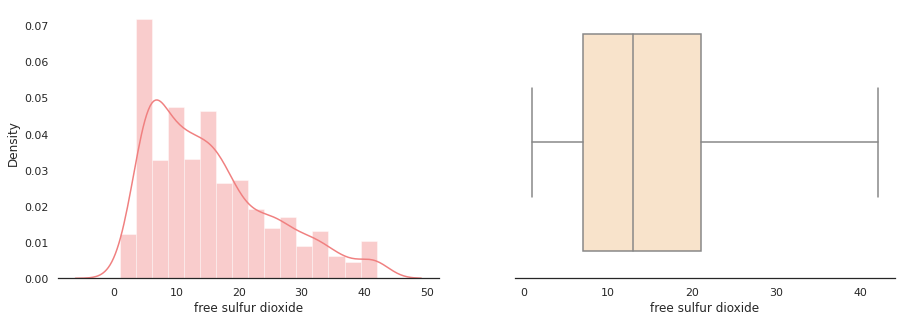

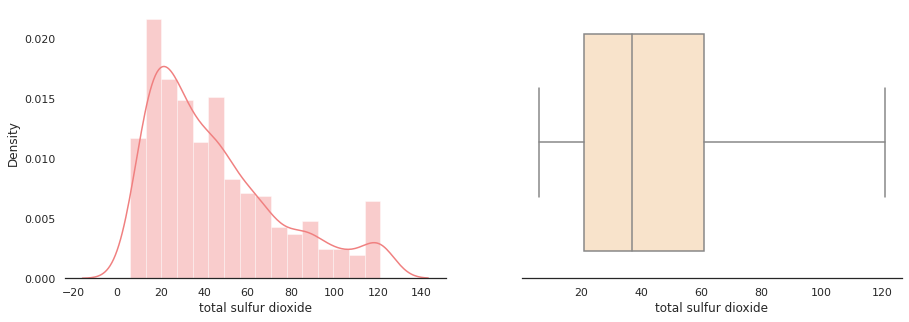

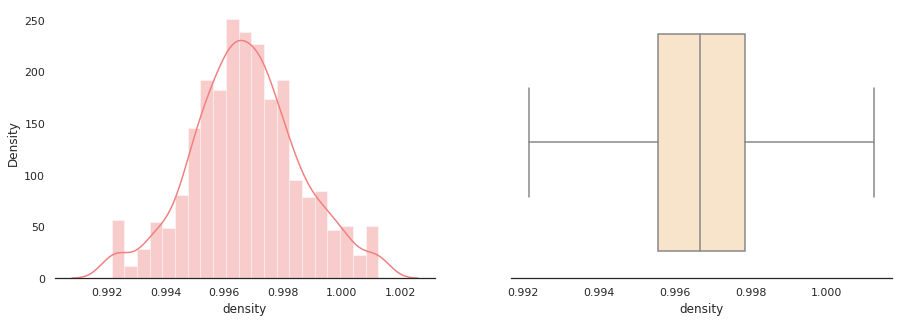

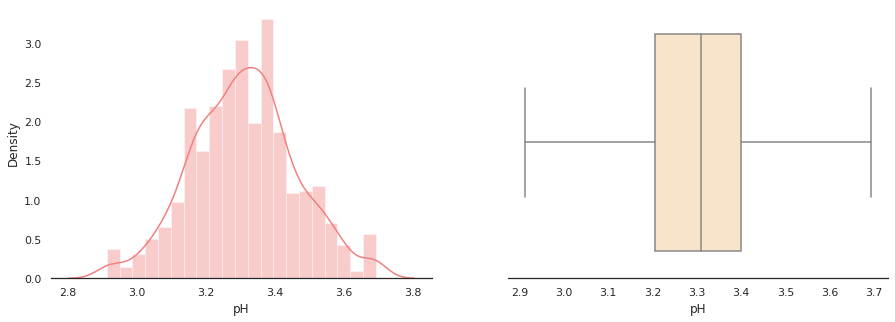

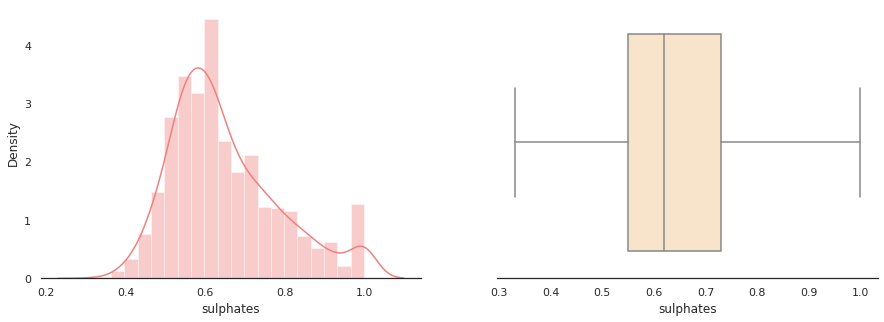

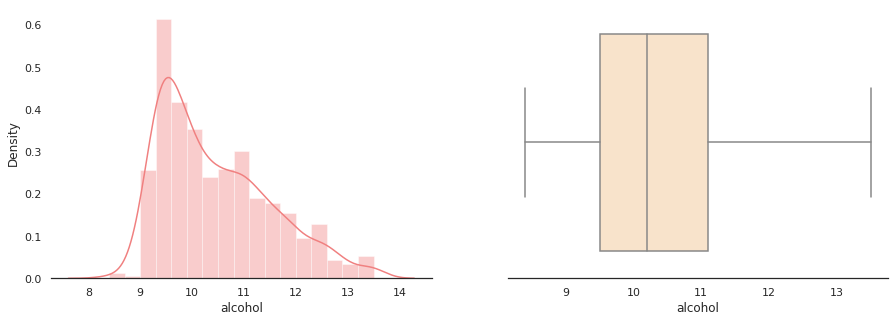

In [51]:
visualization(features)

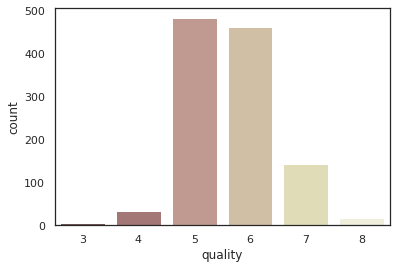

In [52]:
sns.countplot(target, palette = 'pink')

In [53]:
# Creating a new variable called `target` that is a categorical variable with 3 categories:
# "dry","medium","sweet".
target = pd.cut(target, 3, labels = ["dry","medium","sweet"])
target

0       medium
1       medium
2       medium
3       medium
4       medium
         ...  
1138    medium
1139    medium
1140    medium
1141    medium
1142    medium
Name: quality, Length: 1143, dtype: category
Categories (3, object): ['dry' < 'medium' < 'sweet']

**imbalanced data**

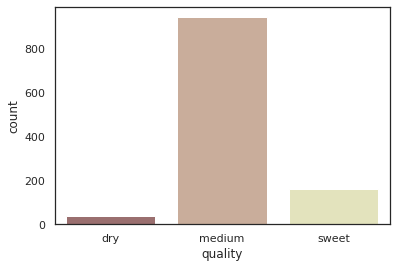

In [54]:
sns.countplot(target,palette ="pink")

# Resampling

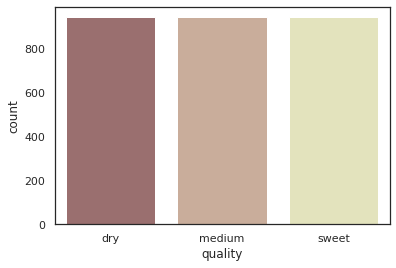

In [55]:
# Fitting the data and then resampling the data.
oversample = SMOTE()
r_features, r_target = oversample.fit_resample(features, target)
sns.countplot(r_target, palette = 'pink')

# Splitting the data into training and testing sets

In [56]:
x_train,x_test,y_train,y_test = train_test_split(r_features,r_target,test_size=0.2,random_state=42)
x_train.shape,x_test.shape

((2268, 11), (567, 11))

**Label Encoding**

In [57]:
enc = LabelEncoder()
y_train = enc.fit_transform(y_train)
y_test = enc.fit_transform(y_test)
y_train[:5]

array([2, 2, 2, 2, 1])

In [58]:
# Counting the number of occurences of each value in the array.
print(np.bincount(y_train),np.bincount(y_test))

[756 746 766] [189 199 179]


# Scaling

In [59]:
scaler = StandardScaler()

In [60]:
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

**Logistic Regression**

In [64]:
lr = LogisticRegression()

lr_model = lr.fit(x_train,y_train)
y_pred_train = lr_model.predict(x_train)
y_pred_test =lr_model.predict(x_test)
print(f"Train accuracy: {accuracy_score(y_train,y_pred_train)}")
print(f"Test accuracy: {accuracy_score(y_test,y_pred_test)}")
print("*"*25)
print(classification_report(y_test,y_pred_test))


Train accuracy: 0.7222222222222222
Test accuracy: 0.7336860670194003
*************************
              precision    recall  f1-score   support

           0       0.76      0.76      0.76       189
           1       0.65      0.61      0.63       199
           2       0.79      0.84      0.82       179

    accuracy                           0.73       567
   macro avg       0.73      0.74      0.74       567
weighted avg       0.73      0.73      0.73       567



**Support Vector Classifier**

In [66]:
svc = SVC()
svc_model = svc.fit(x_train,y_train)
y_pred_train_s = svc_model.predict(x_train)
y_pred_test_s =svc_model.predict(x_test)
print(f"Train accuracy: {accuracy_score(y_train,y_pred_train_s)}")
print(f"Test accuracy: {accuracy_score(y_test,y_pred_test_s)}")
print("*"*25)
print(classification_report(y_test,y_pred_test_s))



Train accuracy: 0.9012345679012346
Test accuracy: 0.8853615520282186
*************************
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       189
           1       0.91      0.75      0.82       199
           2       0.87      0.96      0.91       179

    accuracy                           0.89       567
   macro avg       0.89      0.89      0.88       567
weighted avg       0.89      0.89      0.88       567



# Hyperparameter tuning

In [69]:
params = {
    "C": np.arange(0.1,1,0.1),
    "kernel":["linear", "rbf"],
    "gamma" :np.arange(0.1,1,0.1)
}
# Creating a grid search object that will use the SVC object to classify and the parameters in the
# params dictionary to do a search on.
grid_svc = GridSearchCV(svc, param_grid=params, scoring="accuracy", cv=10)

In [70]:
grid_svc.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'gamma': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [71]:
grid_svc.best_params_

{'C': 0.9, 'gamma': 0.7000000000000001, 'kernel': 'rbf'}

In [81]:
svc_tuned = SVC(C = grid_svc.best_params_["C"], gamma =grid_svc.best_params_["gamma"], kernel= grid_svc.best_params_["kernel"])
svc_tuned.fit(x_train, y_train)
pred_svc_tuned = svc_tuned.predict(x_test)

print(f"Train accuracy: {accuracy_score(y_train,svc_tuned.predict(x_train))}")
print(f"Test accuracy: {accuracy_score(y_test,pred_svc_tuned)}")
print("*"*25)
print(classification_report(y_test, pred_svc_tuned))

Train accuracy: 0.9933862433862434
Test accuracy: 0.9523809523809523
*************************
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       189
           1       0.95      0.92      0.93       199
           2       0.95      0.97      0.96       179

    accuracy                           0.95       567
   macro avg       0.95      0.95      0.95       567
weighted avg       0.95      0.95      0.95       567

